# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification on balanced randomly generated sequences
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7)
import seaborn as sns

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Generate Synthetic data

In [3]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 2
        elif m2 in seq:
            c = 1
        else:
            c = 0
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

def print_motifs_in_seqs(df, df_name, m1, m2,seq_col='upstream_region'):
    print(df_name)
    seqs = df[seq_col].values

    print(f"{m1}:",len([x for x in seqs if m1 in x]))
    print(f"{m2}:",len([x for x in seqs if m2 in x]))

    print(f"NO {m1}:",len([x for x in seqs if m1 not in x]))
    print(f"NO {m2}:",len([x for x in seqs if m2 not in x]))

    print(f"BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
    print(f"NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))
    
def balance_seqs_for_motifs(seqs, m1, m2):
    both_seqs = set([x for x in seqs if (m2 in x and m1 in x)])
    m1_seqs = [x for x in seqs if (m1 in x and x not in both_seqs)]
    m2_seqs = [x for x in seqs if (m2 in x and x not in both_seqs)]
    neither = [x for x in seqs if (m2 not in x and m1 not in x)]
    
    print(f"{m1}:",len(m1_seqs))
    print(f"{m2}:",len(m2_seqs))
    print(f"NEITHER: {len(neither)}")
    neither = u.downselect_list(neither, int(np.mean([len(m1_seqs),len(m2_seqs)])))
    print(f"NEITHER ds: {len(neither)}")
    
    balanced = m1_seqs+m2_seqs+neither
    print(f"BOTH:",len([x for x in balanced if (m2 in x and m1 in x)]))
    
    random.shuffle(balanced)
    return balanced

In [5]:
seq_length = 300
syn_seqs = []
for i in range(150000):
    my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
    syn_seqs.append(my_seq)

syn_seqs_balanced = balance_seqs_for_motifs(syn_seqs,m1,m2)

CACACA: 9217
GTGTGT: 9195
NEITHER: 130983
NEITHER ds: 9206
BOTH: 0


In [6]:
syn_df = pd.DataFrame(enumerate(syn_seqs_balanced), columns=['id','seq']) 

syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)
syn_df['reg'] = syn_df['id'].apply(lambda x: syn_motif_dict[x])
syn_df = syn_df[syn_df['reg'] != 'skip']
syn_df.head(5)

,id,seq,reg
0,0,TACACGGCGATGTTTTCGACTTCTGCCTAAGCGTGCTATTGTTTTC...,0
1,1,GCATTAACCGAATCTAAGACGCCAGATGTAGCTCATTTGGCACACC...,2
2,2,GGTCTTGTTACGCAGCTACTCCGTAATCCCCTTGATGAAAGTTAAT...,0
3,3,CCTTCGCGCCCGGCTTAAAGGTTTTAGACCCATACTGTACATCCCT...,0
4,4,GCCATGGAGATCTTCCGAGCTTTCCCTTTCTTGGGACAAACTCTAG...,2


In [7]:
syn_df.value_counts('reg')

reg
2    9217
0    9206
1    9195
dtype: int64

In [8]:
print_motifs_in_seqs(syn_df, "syn 10K", m1, m2, seq_col='seq')

syn 10K
CACACA: 9217
GTGTGT: 9195
NO CACACA: 18401
NO GTGTGT: 18423
BOTH: 0
NEITHER: 9206


In [9]:
syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)


In [10]:
loc2seq = dict([(x,z) for (x,z) in syn_df[['id','seq']].values])

#print(locus2info['4'])
print(loc2seq[4])

GCCATGGAGATCTTCCGAGCTTTCCCTTTCTTGGGACAAACTCTAGTTAACTTTAGGGGATAGAATTAATTGTTTTCATCGCTAGATAAATCGTAACACCTATTCGCCATCATTGCAACCAAACCGCACACCTAGCTCCCAGATGCAAGACAATGTATAGTACGTTTGGACGCCCTGTCGGACGCAAAGAGTAGAGTAAGCTGGACAACTCAAGGCACACACGTGATGGCGAGAGGGTCACGAACGCTTTTCTGAGGCTTGGGATACGCAGTAATACTAATCTGCCCGGTTCGAGGTTTG


In [11]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x='reg', y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in [0,1,2]:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


## Load 5G seqs into data loaders

In [12]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [13]:
full_train_df,test_df = tu.quick_split(syn_df)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='reg',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

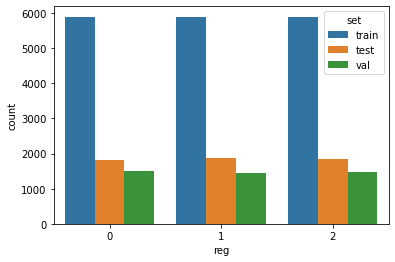

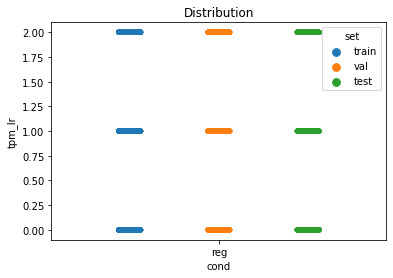

Train Seqs
CACACA: 5899
GTGTGT: 5897
NO CACACA: 11776
NO GTGTGT: 11778
BOTH: 0
NEITHER: 5879

Val Seqs
CACACA: 1481
GTGTGT: 1437
NO CACACA: 2938
NO GTGTGT: 2982
BOTH: 0
NEITHER: 1501


In [14]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='reg')
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df,id_col='id')

print_motifs_in_seqs(train_df, "Train Seqs", m1, m2,seq_col='seq')
print()
print_motifs_in_seqs(val_df, "Val Seqs", m1, m2,seq_col='seq')

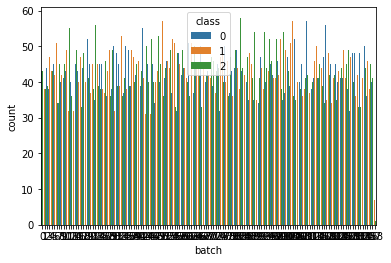

In [15]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [16]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs): #tqdm?
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [17]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [18]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        
        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

In [19]:
seq_len = len(train_df['seq'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=1500
)

0 1.0990463025053585
1 1.0988704973714172
2 1.0988241845489384
3 1.0987245547714803
4 1.098394947317451
5 1.0982593669425202
6 1.0980410784395283
7 1.0980034911759327
8 1.0975687610371994
9 1.0973655745086963
10 1.0968812278126883
11 1.0962647465889097
12 1.095487764044082
13 1.0951680999504654
14 1.09373938508583
15 1.0925347299752772
16 1.0910747251944404
17 1.0909580321947518
18 1.088155465094745
19 1.0868786892272628
20 1.0871662473915982
21 1.08829418669785
22 1.0914276515663304
23 1.0857366350717366
24 1.0888107721286004
25 1.0961752689162594
26 1.0888845095890198
27 1.0909915574402473
28 1.09353621781857
29 1.100485370800651
30 1.1200655014651424
31 1.1153564466073735
32 1.1038120794307056
33 1.105099030090258
34 1.1084910818127167
35 1.1045775527219261
36 1.1055752717145673
37 1.1081626982704011
38 1.1239720466962955
39 1.1168351360348237
40 1.1344369345456935
41 1.120104579343923
42 1.1408242575046998
43 1.1310230155799368
44 1.1305386862163496
45 1.1327554306365646
46 1.13748

368 3.4560320159919016
369 3.458150099672109
370 3.4596025463573854
371 3.461163641344128
372 3.4630998322045974
373 3.4645924061017492
374 3.466485025764564
375 3.4683292794750944
376 3.469584771534198
377 3.4712200930388866
378 3.472537054360574
379 3.4753987680168867
380 3.4761620094992507
381 3.4782068493086227
382 3.479376135759425
383 3.481141982075315
384 3.4823063082434955
385 3.4837332488886776
386 3.484705059958357
387 3.486869370621722
388 3.489504870852617
389 3.49008747543461
390 3.4912645656562384
391 3.4934475670629133
392 3.495067925279457
393 3.495873973282734
394 3.497144952568163
395 3.499526663586197
396 3.5018185315884245
397 3.5017004364835485
398 3.503839327593577
399 3.5051375610522486
400 3.506634336813836
401 3.509117628767847
402 3.509080787405328
403 3.511099777979181
404 3.512705721124639
405 3.5138521964368197
406 3.5158870947471597
407 3.51681776013302
408 3.5192428380824183
409 3.5206036617324803
410 3.5209118832180093
411 3.522608123825912
412 3.5234294

733 3.8413815781605622
734 3.842034011168781
735 3.842664691003962
736 3.8435541356572958
737 3.8442767211338276
738 3.845380486069451
739 3.8458691518968737
740 3.8466977582147255
741 3.8471273763548277
742 3.847605246444395
743 3.848554454850082
744 3.849392303489241
745 3.8501501087150736
746 3.8508155429004463
747 3.851671525433366
748 3.8520602037745326
749 3.8527992443413615
750 3.8537166886373893
751 3.8541827825001125
752 3.8549494942433964
753 3.8553747379232193
754 3.8566247654543875
755 3.857240507898894
756 3.858242685478126
757 3.858421573813724
758 3.858776843340102
759 3.8602642643961547
760 3.860522582482957
761 3.8613042101975505
762 3.861977161555086
763 3.862679952084951
764 3.863282070949785
765 3.863773191803369
766 3.864812878845881
767 3.865416618298826
768 3.8658337746305307
769 3.866782223377111
770 3.867418599252815
771 3.8681727279551725
772 3.869004645750085
773 3.8694467208967622
774 3.870175979341903
775 3.870848980336255
776 3.8715261644193775
777 3.87196

1095 4.046159457664032
1096 4.046806656847607
1097 4.047014738321574
1098 4.047603103849623
1099 4.048207213366617
1100 4.048466483940769
1101 4.049083749318344
1102 4.04962166803243
1103 4.049981569105426
1104 4.0503590553695465
1105 4.050860577402246
1106 4.051149425800096
1107 4.051507328505645
1108 4.05230051372137
1109 4.052805219200516
1110 4.053143816691336
1111 4.05357188654043
1112 4.0541130534446355
1113 4.054503745206154
1114 4.05503932397596
1115 4.0552164669839685
1116 4.0557158595972345
1117 4.0560750028994805
1118 4.0565234147253335
1119 4.0570883512443
1120 4.057386425507772
1121 4.05811880961563
1122 4.058256471175958
1123 4.0589548585425135
1124 4.059342258627745
1125 4.059647473902636
1126 4.0603347162392165
1127 4.060786191304093
1128 4.060972122996068
1129 4.061728464097668
1130 4.061857477629662
1131 4.062213370745526
1132 4.0628231343275605
1133 4.063001279621595
1134 4.0638233961414825
1135 4.06447812166924
1136 4.064388435980561
1137 4.064818672314843
1138 4.06

1451 4.184468572132726
1452 4.184737363102264
1453 4.18513484129568
1454 4.18536055991757
1455 4.185663409782335
1456 4.186022000443372
1457 4.1863505470183515
1458 4.1867560157680925
1459 4.187027467864486
1460 4.187547172888233
1461 4.18770727158456
1462 4.188069179981212
1463 4.188390551500392
1464 4.188896028939943
1465 4.189166963248804
1466 4.18956488941449
1467 4.189680452556139
1468 4.19005393566495
1469 4.190184959919643
1470 4.190855432727483
1471 4.191065656353808
1472 4.191362651340237
1473 4.191758352859335
1474 4.1920874452234855
1475 4.192292580644478
1476 4.1926522175632845
1477 4.193118273550959
1478 4.193451080421539
1479 4.1937214380261265
1480 4.193964431339272
1481 4.194471262569043
1482 4.194736857251307
1483 4.194980223973592
1484 4.195333368450734
1485 4.195953564936286
1486 4.196092667205217
1487 4.1965031576361636
1488 4.1967757872041735
1489 4.197122064319825
1490 4.197277172357957
1491 4.197624660450076
1492 4.197989564320706
1493 4.198471016569843
1494 4.19

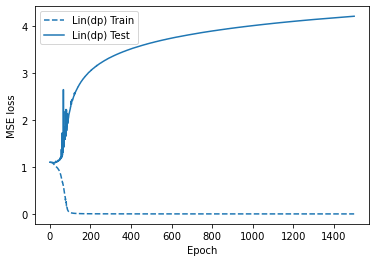

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [20]:
# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [21]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.5),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully connected layer 0
#             nn.Linear(fc_node_num0, fc_node_num1),
#             nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num0, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

In [22]:
# make model
seq_len = len(train_df['seq'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=1500,
)

0 1.0999901264224772
1 1.0997393418556156
2 1.0988332059864114
3 1.0992454568248282
4 1.0987110967467775
5 1.0985792595543293
6 1.098862966225411
7 1.0987819036117747
8 1.0990521070724646
9 1.0982846806129738
10 1.0976211242369327
11 1.097427684517839
12 1.0972425217379216
13 1.0972531416967028
14 1.0968477850344474
15 1.0966243228374981
16 1.096956130632261
17 1.0959114475092702
18 1.0970898044408783
19 1.095314561093277
20 1.0945922850645298
21 1.093628824633909
22 1.0944232748600928
23 1.0920005959066015
24 1.0917121460060644
25 1.090105660632337
26 1.088969268392022
27 1.0902096255382927
28 1.0842858243781697
29 1.0838729019320423
30 1.0871546164333725
31 1.0781652117023697
32 1.1027793046656063
33 1.0823107196022737
34 1.0771462429052674
35 1.0744885779473814
36 1.0924392730894605
37 1.1123119169404858
38 1.0690060018494971
39 1.0639448844083539
40 1.0656711218394315
41 1.0612792137603086
42 1.0751754388897687
43 1.0838636965146295
44 1.155345206806686
45 1.0601017599220215
46 1.0

351 0.023841428649482157
352 0.03234489511721246
353 0.024437681821763556
354 0.02971065317118942
355 0.02310417926697257
356 0.8551287597378715
357 0.024600588331518736
358 0.021182716120406227
359 0.02368071650389458
360 0.025244686665727045
361 0.0244144658969252
362 0.024964516116236637
363 0.023321880872354407
364 0.023157903997083815
365 0.02121612182235618
366 0.023284298021107756
367 0.023707917208810093
368 0.021562108575276025
369 0.02271068196395561
370 0.020439482105398074
371 0.16738177503792778
372 0.022986778726834575
373 0.023402183458485548
374 0.02177682380746476
375 0.024130115249266074
376 0.024257376954856434
377 0.023750909531000487
378 0.023699367679798865
379 0.023998817399019406
380 0.024564941430350158
381 0.025158142590059444
382 0.022417241338624435
383 0.024183163349395506
384 0.029190347417615798
385 0.022596438721995814
386 0.024257753247955344
387 0.023929374082160226
388 0.022980892810313836
389 0.023748506865021356
390 0.022921377714132395
391 0.023141

684 0.017445873553205208
685 0.017256172649346545
686 0.0173653490094476
687 0.017042771668847153
688 0.01678396730921264
689 0.01686614656618148
690 0.01702573642570506
691 0.015834446845550455
692 0.01710678970714781
693 0.016630604143862904
694 0.016213395512041314
695 0.016974923105644447
696 0.01687249757706087
697 0.016898513637132424
698 0.01621179833407989
699 0.01632366980640772
700 0.015998894001417744
701 0.01616155357749403
702 0.016505003965586847
703 0.01723953188190662
704 0.0170579864598202
705 0.01702267517556794
706 0.015601023461127624
707 0.01760826800225088
708 0.01702900458014296
709 0.016158365661374893
710 0.01655339677848679
711 0.017250922204841045
712 0.016604318278650942
713 0.015363722738248646
714 0.015420866227078812
715 0.015507446991249793
716 0.01622109842056952
717 0.016196216648378357
718 0.017300410397666076
719 0.017489507204268576
720 0.016611441171956322
721 0.01641554971362339
722 0.01580083227380655
723 0.015913124859053156
724 0.01607829007221

1015 0.014047882580781082
1016 0.013515097535699842
1017 0.01443374863231201
1018 0.014598744544347073
1019 0.013545201008692198
1020 0.013644977673992741
1021 0.015213303346356323
1022 0.01445474184697153
1023 0.01355658615002517
1024 0.01270974190004927
1025 0.013043895860344448
1026 0.013945451450773793
1027 0.01413440449501789
1028 0.012885186216990167
1029 0.015809096435380417
1030 0.01381750954376185
1031 0.023956768680890778
1032 0.014107881688191883
1033 0.014449518378575306
1034 0.014224682236353745
1035 0.014068628008418169
1036 0.013036295285178245
1037 0.013709709365666924
1038 0.014099572908700618
1039 0.014310755252055815
1040 0.012439354376171503
1041 0.012564082513220859
1042 0.014184234739504847
1043 0.013395500981400027
1044 0.012614611739009908
1045 0.013229663261663633
1046 0.01261032044906089
1047 0.013089088585019502
1048 0.013885421768626656
1049 0.011497545759120889
1050 0.01457516469683521
1051 0.013379949257351014
1052 0.013818276484213849
1053 0.0144583226733

1334 0.013975285395135179
1335 0.013391974443221192
1336 0.011351943760435893
1337 0.011702680116859489
1338 0.012029907987336075
1339 0.01148290129963913
1340 0.012884201747910095
1341 0.012289927492786935
1342 0.014094782690132979
1343 0.015553220007235606
1344 0.013485972147201434
1345 0.012261122276930214
1346 0.011427173010784055
1347 0.01169242509237159
1348 0.01143977164562086
1349 0.011535208546886363
1350 0.011105245315204461
1351 0.01266485662373429
1352 0.012531852101792062
1353 0.012009583715190106
1354 0.019587971410446645
1355 0.01195277165411608
1356 0.012908880886944016
1357 0.011247739232494891
1358 0.012891593922421077
1359 0.010917904441128775
1360 0.012956795495523603
1361 0.011897805758481532
1362 0.011395891421689697
1363 0.010899859739787427
1364 0.01167625144990652
1365 0.01345547408153836
1366 0.011240767328307609
1367 0.012025590973789671
1368 0.01303304313583176
1369 0.013063867460294773
1370 0.01206265390277563
1371 0.02017960948547132
1372 0.012069022652831

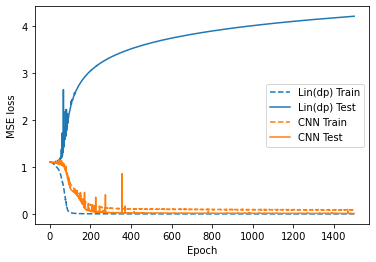

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [23]:
# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

Running LinearDeep
Running CNN
Running LinearDeep
Running CNN


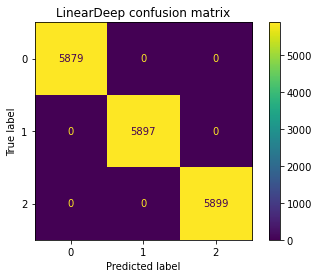

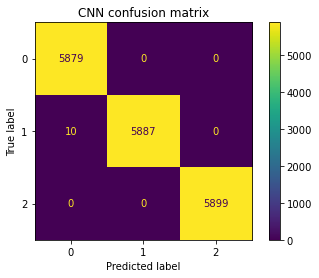

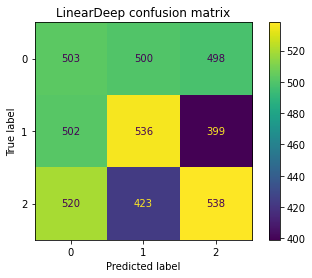

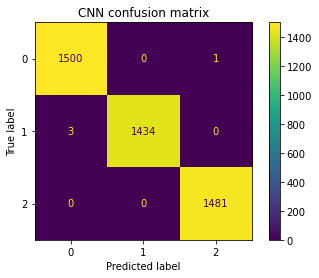

In [24]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['id'].values #val_df['locus_tag'].values #
val_seqs =  val_df['id'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [25]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    #return pred
        

In [26]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.357)
micro: p=0.357	 r=0.357	 f1=0.357
macro: p=0.357	 r=0.357	 f1=0.357

CNN (acc=0.999)
micro: p=0.999	 r=0.999	 f1=0.999
macro: p=0.999	 r=0.999	 f1=0.999


## Rebalance sampler

In [33]:
from torch.utils.data.sampler import WeightedRandomSampler


In [34]:
# retry making dataloader with weighted sampler
class_sample_count = train_df['reg'].value_counts().values
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_df['reg'].values])
samples_weight = torch.from_numpy(samples_weight).double()


sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
sampler

In [35]:
print(samples_weight.unique())

tensor([0.0008, 0.0256, 0.0278], dtype=torch.float64)


In [36]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg',
    sampler=sampler,
    shuffle=False
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [37]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1761, 17)
(441, 18)
(1408, 19)
(353, 19)


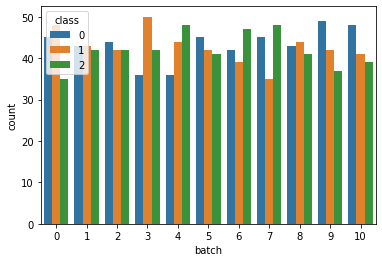

In [42]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

In [43]:
# make model
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=3,
    num_filters1=3,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=500,
)

0 1.2379393212856045
1 1.2285758358223242
2 1.2148800544630705
3 1.2087449618844743
4 1.2001219690690297
5 1.194572628050958
6 1.1862099109898208
7 1.1741604224142879
8 1.1686981308561546
9 1.162313221196615
10 1.156669128380146
11 1.1572663223439505
12 1.1530000960860645
13 1.1494160806153382
14 1.1455422251487926
15 1.1401522713409942
16 1.1354394931631115
17 1.1314044886878125
18 1.1255257734158222
19 1.1229182637109296
20 1.120118280645808
21 1.1157057734454319
22 1.1124703624093162
23 1.1138245262437771
24 1.1095508965149141
25 1.1102224389149178
26 1.1079142677885276
27 1.1089623713966132
28 1.109194352674079
29 1.109567305183951
30 1.1080352858173272
31 1.106149552901811
32 1.1041910945524913
33 1.1035687234516522
34 1.104340605965417
35 1.1046943421404356
36 1.1012169831873
37 1.1003087867083023
38 1.1013526886110603
39 1.1008091263325288
40 1.097388355319966
41 1.0973565369084604
42 1.0972029075406429
43 1.1000946533916354
44 1.0996481186945108
45 1.0991333658904596
46 1.09810

372 1.0906067249119789
373 1.086846680208914
374 1.088314790225907
375 1.086557674002715
376 1.0866035425629224
377 1.0896486033798953
378 1.0884291963604287
379 1.0934943936701875
380 1.0920329830126452
381 1.0919253826141357
382 1.0903535439677685
383 1.089841453617085
384 1.0875580057544005
385 1.0848251999944196
386 1.088316546958837
387 1.089065146851472
388 1.0889317476040243
389 1.0888072356961604
390 1.08784365282518
391 1.093097187304294
392 1.0932643204167611
393 1.093135843533632
394 1.0919941282137258
395 1.0943762222700686
396 1.0931640606764017
397 1.0885991310600518
398 1.0885301993859051
399 1.0907828243866182
400 1.0868906647220211
401 1.0869889225568041
402 1.088285461701347
403 1.086053380209731
404 1.0847984150516412
405 1.083701588276763
406 1.0840032495790433
407 1.0838543139503631
408 1.0875103220385802
409 1.0915610253304326
410 1.0918234654256371
411 1.0954377610690196
412 1.0955882153497538
413 1.0933735758994862
414 1.0934484180580117
415 1.0954216188479415
4

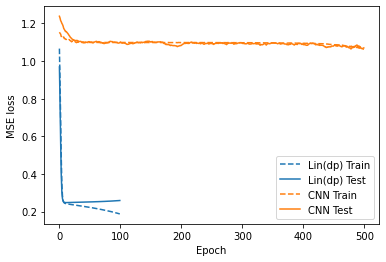

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 3, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(3, 3, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=279, out_features=10, bias=True)
    (8): ReLU()
    (9): Linear(in_features=10, out_features=10, bias=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [44]:
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

Running CNN
Running CNN


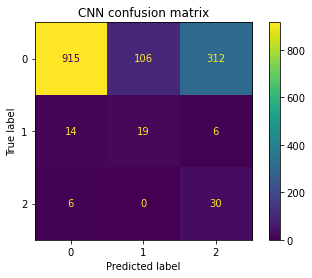

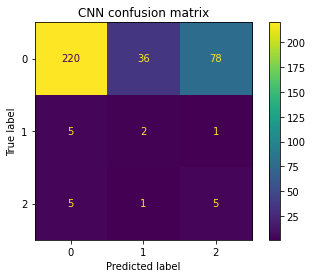

In [45]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

# filter viz

In [27]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


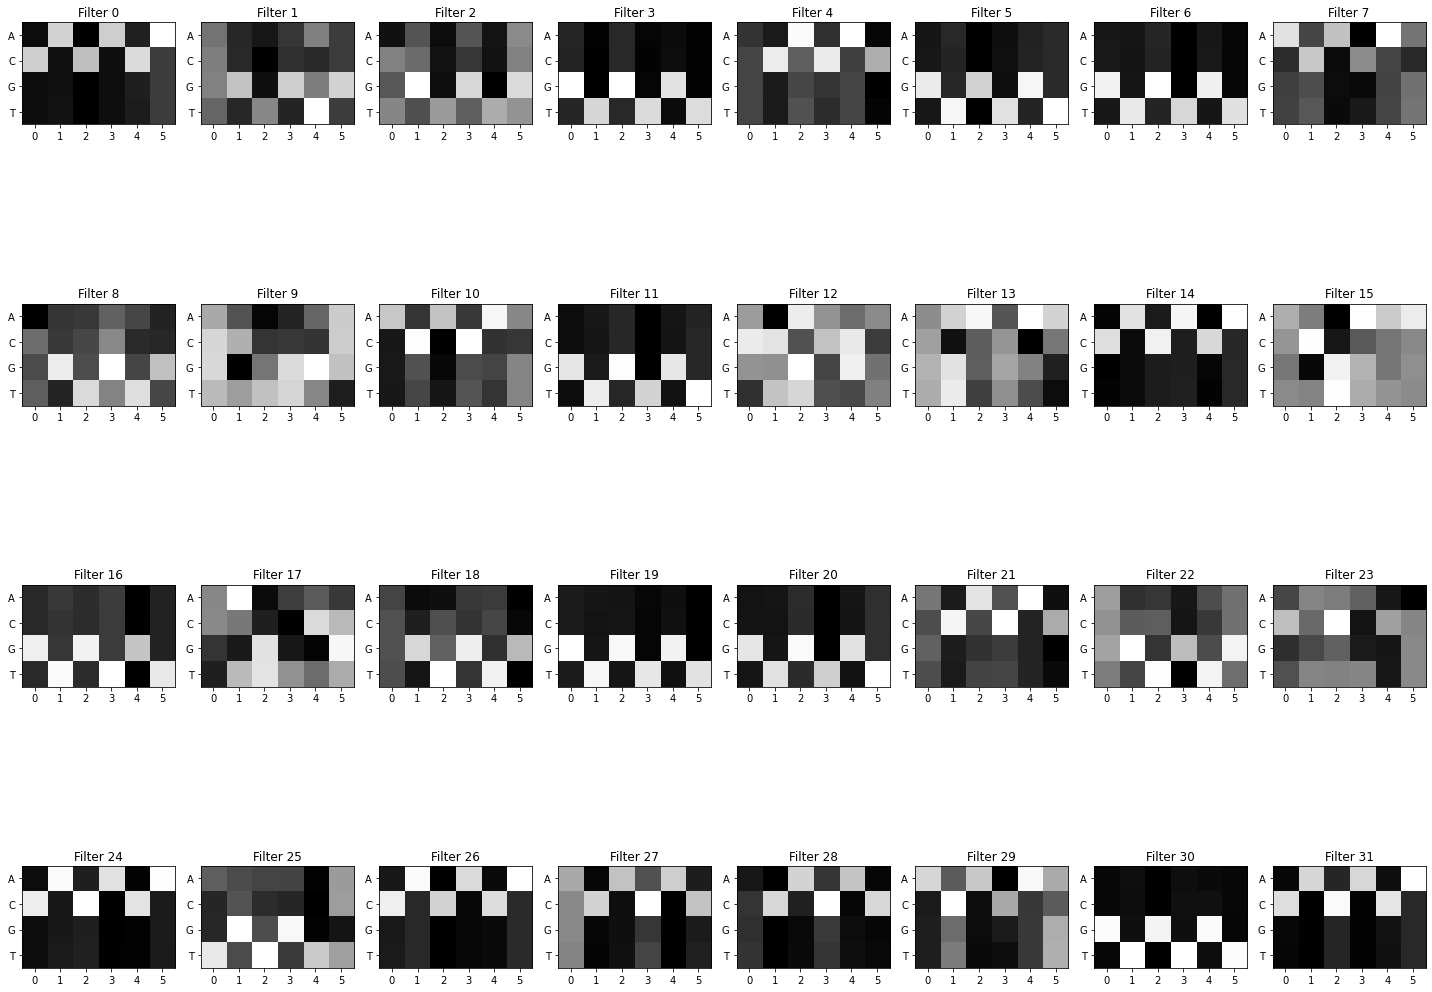

In [28]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [29]:
seqs = [loc2seq[x] for x in train_df['id'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 32
filt_width 6
Running seq TACACGGCGATGTTTTCGACTTCTGCCTAAGCGTGCTATTGTTTTCGAGGTCTGGTGTGGATCAACCCCCAACTGAGGCTGCTTCTGCGTCATTGCCACATGCTTTTGAGGGCATCCTGTACAACCACGTAATAACTTGTTGTAAAACCACCAGGAGCCCACCGCTCCCGATACCCTTATCTTTGCCGAATTGTTATGTGTTCTCGCGAATTGTTAAGGGTAATTGGGGGAGGGGAGTACAACTTGCAGAGAGATACAGAGCACCCTGAGGCGCAGATTGCAGTTTACGGGGTTACGTTA
Running seq GGTCTTGTTACGCAGCTACTCCGTAATCCCCTTGATGAAAGTTAATTTGGACGGTCCACCTATCCGACTTGCGACGCGTCCCGGACGTGCGGGATAAGTCTCCAGCCTGTCTGACTAGGCATTAGATACACTCCACATACGTAAGAGAGCTAACAACCAGGAGTACGACTAATACGGGACCGGCGATTCGGGGACACCACCCACTGATGGAGGAAAGGACACCTCGATCCGAGCGCTTTCTACGAATAATAGGGATGGTATTGAGAGGGGCTCTGAGTCGCCGCCGGCCTCCCCTGGTTA
Running seq CCAGGTTATAAGCCCAATGGTAAACAGGCAGTAGCTTCGGTTGCCATGAAGAACAAGTACTGATTAGTGTCAGAGCCCTTCCGTAGATGAAACCTAAAGGCTGGACGCCTCAGTTTCTTGAATGTTAGATATCTATTGCTACCTCGGTCCCGCATGCACTAAGGCCGACATAGCTCTCTTGACGTATTTACCCGACCATCCTCCTTGTTTTAGAGCACTCGCTCTATTGTGCGATCAGCCGACCCGAGAGTACAAGTTATATGATTCGACAAAGAGCAGGACCTGGACCGGCTAACTTCA
Running seq GGAGCCAGAATTGCTTTTGGA

Running seq AGCTCAGAGAGACGGCTTCTGTTCTCACATTTGATATAACTGCATATGCATGGCTTGGTACCTGAAATGTGCCCGGATTCGCTACAAAGCTAATTTTCCACGTGATCTTGCCGAGGTCCAATGAAACTCTAGTCGCTGCCCTCTTGACTTGATGGTTGCCGCTTTCGCACACCTAGTTGCGCCGGGGCTCCTCATCCCATAGGAGTACGGTCAGACGTCAATGTTCTCGTTGTCGCCCCGAGTCACACATTGCTTCAGGGTATGCCCTTTCACACTGTAGTAATGAGCAAGACCATTTGG
Running seq AGCGATTATATGAATGCGAGTTACGTGTGTTGTAAGCTTAAAAGCCGCTGCAATGACAGCGGTTCGTACTTAGTAATATATAATCTGACGTTGGGGAGAATGTAATCGCCGTATGTATGTTAGAACGAGAACAAACTGATGGTTAGGCAAGTTAGAATGGAGCCCGTTTGTCCGACTTCTTCTTTGTTCTCTCAAATCTGTCCATCACTCTAGTGGAGTACAATCTTAGACTGCGCAGTCTGTTCTAACCAGCGCGGTGTATTATGTGGAAGGGACTCATCCGCGGGATAGGTTAATCCA
Running seq GGGCCAGGTCAACTTTGAGCTACGTATAACGAGACGACTATTGGTAAATGATAAACGTGGCCTCAGAGTCAAGCCGATTATGTGGCATGCACTCTTATCTCCGTGTCTATATAAGTATAACAAGGTAAAGACTTTATGGTAGCCTAAATACCCGGATGATTCTGCGATTGCCTAGGACTGTCGGGATGAGCCAGCGGTAACTACCAGCACACATTCTTGACGATGACCGGACCATTAGTAATAACGCGTATAGATTGTGCTGTATCCGATCAGGACGAGGGCGGCACAGGAAAGGCACAG
Running seq GCCACCGTGTCCCGGCAACTATTCCGGATATACTGGTTATTCTGGATCG

Running seq ATTGGATCTGCACTAGTGAATGCACTGATGCAAGGCCGATGTCCACATAACATTAAAGTAGGCAATCGACACGTGATAGCGAGACAGGAGTCGTGCTGCAATTCGATGGCCATACACGAGCCTGTAGGGGCCGGAGGAGGGCTTGACGTATCTAGTTAGAAAATACCTGTAGCCCCGGGCGAATAAGCATCGTAAATTGTAAGATAGATCCCCAGTAGAACTCCTTGCCTAGTCGCCGCAACCCGGGTTCTTCGCTCTGACCGACGCGGAGGAGCACGTGTGTTGAAATTCACCGTCTCG
Running seq TCCTCGCACACAACCGGATGTGTATTACTCGTTACCAGGTCATGGCCTACTCTGAAGCACACAGTAAAAGGGGGTCAGTAGAACTACACGGAGTGCTTGATGATCATCCATTCTGTGAAGGCTAGCCAGTCCTGGCAGAAACCCGCTGCCCAACCGGAGATATCATTATTCGTGGTTAGACCACTGTATGATTCTATAAGCCGTGCCCCCCTTTCTTACAGAGATAACGCCCCGCCATCATAATCTCTAGAACATAGCTCAACGTGCGCTACAGATTTCCTGTTATGGATACCCCACGCC
Running seq ACCGCTTTTCGTGCACGGTTCGCGGCTAGTCTGCTGCTTAGAACAGCTTAATCAATGACCTAGGAATTCGCTACATATTATTTGGTCATAATTCCCCTAATTAAAGAGCGGAGGGCAACTGCGACTATGGACGGTATGCTCCTGACACCGTTTAAAGACGAAGCCCTTCTAAGGAGAGGGTCTCGGCCGATAGGTTGGCGCGTGTGTAGACTGGATACAGCCCCGCAACCGCGCTAGGGTACCCGCTATTGCGGATGTGGTAAATCCCGGCGAATACGGTAAGCGGTCGGATCAGTCCAC
Running seq AGCAGGGCAACACTTCAGTACGCAGTCGCGTTCGTTCCGCCGCCCGAGG

Running seq GATGAGCATAAATCTAGTGTGTTTGACACGAGGTTGCTCTACGTGGGAAATGAAAGATCACATTGATCTCTAGGAATCTGATACGGCATGATGGTACCGGAGAAGCGAATCTCTGCAGGGGAGGATTTATACCCCGTTCGGGATTCTTTTGCATAGGGTCTTTACCATTTGTGCTGGATAGACGACTGAGCCGCGCGAACATTATTTCGCCGAGAGCAGCGAAACTGAAGCCCACAACAGGGCCCTCGTCTGCGGCAGAATCAAGGAGTAAGCGGCGTGTCGGGGCCTTGTAAGGTCAGT
Running seq TGTACGCCCACTTTCGTACGTCGGTATTACCCCGAGACTGATATGCAGCCAAGCAAAGGATAAGCGCACACCACATTATCCAGCTGTTCGCTGGCGAGACACTGGTGGTGAGTCGCACGGGCATTGCAGAGACTCCAATGCACCCAAAATGGCTCAGTAATAGACTACGATGCACAGGTACTCGTGAAACTCCTGAACCTGATCGGTAACGAACCGCGGCGGACCTTGCAACTCACAGCGGGAGGACCTTGCAATAAAGGTAGTTTTATGGTAACGATCGGAATATATCCTGATCATCGA
Running seq ATTAGCAGAGGGGTTGTGGTCCACCACACCAGGTCAGAAGACGGGATGAACCCCAAACAAGTAACAGACATCCATTCGTAACCCTAGCGACGCATAGGCTCCGCTCTACCCAGCCACTTTTTATTTGTGGGTAGATAATCCACAGGACACCCGTTTCTGAAACCAGCGTACTGGACGCGGGCTCCAAAGCACGACTCGAAGCAAAATTCGTCTCTAACATAATCAAGGGGCGAGCCTATCAAGTGCTTATGACGACTGTCGTACCCCGGTACGAAAATCGTCGTAACGGTTCGAGTAAAG
Running seq GTTTGTTTACACACACTCAAGCAAATTCAACTTCAAAATCGGGAGACGA

Running seq TAGTGCTAAATTCCCAGCTGAGTCATCACAATGTACTATAGGTGTGTTGGGTAATATGTTGAACCATGGCACTTGCGGCAAAATAGTCAACATTGTACAAAGTCAACTCCCACATATGCTAGACCTATCTTGAAGATACAATTAATGAATCAACGGCTGTCGCGCAGGTAGAGATTCCTTGCTTCCTGCGGCATCCCTTGGGATCTCGGCCACCCATGGATATATACCCCACCTAGCGTGCCCGTGGATACGTCTGGATCTACGTCGTGGTCAAAATTGCCGAAATTTAGAGTAGGTCAT
Running seq TGGGAGAGCCCAATCAGAACAGCAGGGTGTGTGGCTGGCGATTTCATCCCTTAAACTTGACCGAGCCGGTATAAGGCTAGCAATGGACGCTTCGGAGTAAAGCTAGACTGGCGTGTTGGATAAAAGAGATAGTATGCGTTACGGGCGATGGCGCAACTGGAACCTTTTATACTACCGCGAAAGGCTCTTATTGATCGCTTGGGGGGGATGGCAGTGAGAGTCTGTCCTACCATCATTTGGTATGGTCCAGATAGACGCACAGCCGCAGAGACGCCCCAAGTGGACGTTTCAGATATGGGT
Running seq TACCGCGACTCCTATCCAACTAGGCAATGAGCCCCATTCGTATCGAAAACCAGGCAGGCCCAGTTATATGCTAGGACAGCATTTTACGGTAGGTGTAGCTCTAGACTTGGCTACACCATCCTCCCAACCTATTGGTCAGAAGGCCGCTCAAGTAATCCGCCTCGTGGAGATAGTATAGTATTTATCTAGTTTTCCGCCGACCGTGTTGGAGGATCTCTTCCATGTTAATATTTACCCTGGGGACCCAGTAGTAGCGTTTCCCCTGCTGGTTTATTAATATGATGATACGCCATCTGGAGT
Running seq TCGCACACGGCCTTCGGAAAAAAAGTAACACTGCGACGACATTATGACA

Running seq CTAAATATTCTTGTGACCCTTCCCACACAAGGGTTATCAGTTTGTCTCACGGTGTTTGTGCGCATTGCCTTAAAGTAGATCTCGATGGTCCTTGATGGAGTATCAACGCACCTGAGATCAACAGGAGATTACGATCTACCCGCACACGGCCAGCCAGGCATCAACGCAAGGCCCGCTAATTTCCAATTTGACACCTGATTGATAGCGTTAAAGCTTTGCAGCATAGAGTATAATCACGCGACTCGCTCCAAGGTGTACGGAGTCATGTCGGTGGCCAGACCGAATCATACTCTACTGGAC
Running seq CGCCCCGATACGAACCCAGCTCACCGATACTCTCCATAGAAGTTTCAGCCCTCCACGTAATCGGGTCTAACATACGATCTATGATCCCACTCACATCGTGGTCACCAACAAAGGTTGGTGACCATCAGAGGCGATAATGGCGCGGCAGCTAATAGTTTCACGCTGGAATCTTTAGCTGAAAAGCCAAGCCTATAAACCGGTTCGCCGTAGATAGGTCCTTCGAACCCGCCGAGGTTGCCAACGGTTATGTCGCAGTTGGCGACACTTAGATTCTCCGTCTAGCATCAATTAGGAATCATC
Running seq GACAAACGCCTAAGGTAAGCACCGTCCATATCTGCTCTAATGAAATCTTGCAACATGGCAGTCACGGAAGTAAGCCCTCCTAGGATGGATCCGCCAGTGCTGGTCAGGGTCCACCTACTAGGTCAGTTCACCTGTCCCTATAAGCATCAGAGACCGACTCAGTAATTCTGCATCGCGGGCAACTAGAGTAGGGATTCAGGCAACGGCGTCGTGCTAAAGAGAGGGTGATACATTGTGTGTTGTGAGTCGTTACCCCATGACTGCGCTGGTCACCCAAGTTGCTGGCCATCGAGACCGCCC
Running seq CGGTCGCGGTAAACTTACGTGCAACCAAACCTACTCATGCGACGTGTAC

Running seq GTAACCGCCCTTTTGACATAGGGCAATTATAGTGCGGTACTATTATCGCCGGAGGTCTAGATTCGGAACATCCGCAAGTGAGCTTACACGGAACCCGATTAGGTTAGTGCAGTTGTATTATTGTGCCAAGAGTTGATGCCAGCAGGTGTCCCGTTCACTCACGTGTGTAGACCATGCACGGTAGTGGATTTGTTCCACGTCCCACCATTGGATGCATCTATAGCGTAGTGCCTTAAGCTCATACTGATAATGGGCTGTGTAGGGATATAAACTCATTAGAGAGATAGCCCCTCGTCAATC
Running seq ATAGTAATAGTGCTCGACGTTACCACATCAGGATTTGTTGCCGTCTCCGAACGATGGAAGGTTGCCACGCTTCAAATCCTTCGTACCCGGCTGTAATCAAACGCTAGAAGGTGCCACGCGCTCTCGATGTGTGCCTTCCTCGGTCTGGGGGCGTCAACTTCGAAGCTCGAGAGAAGGTGTGTTACGCGGTGCTTTGGCTCTTCTCAAGGGTTATCGAGGCTATTACAGGCGCCGCAGACTCCCCGAGAGTTTACAACACAGCTCCTATCACATTTCTTACAATCGAATCCTAACAGCATG
Running seq AACTTGGGCTGCCCTGTTTATTGTCCTCCAGGGGGGCGGACACGAGTGCTGCACCTTATCGCAATTGGTCCTCGGCACTGACTACTCCATCTGTCGGGGACGCGGTACGTCCCGAACCGTCTCACTCCGTTATTCGAACTCTACTGTACTTAGGTGCACACATAAGGAGGTACTTTTGTGACCCCAGAAAGGTCCCCTGCTACTATAGAGGGGTTAGCCTCGAACGCCCGCCCCTAGAGGAGAAATGCTAACGGGTACGCGGACCATCCTATGCTGGACCTGAGAGCAACCACACTAGTG
Running seq TCGAGGAAACACGCTTCTCTCAGACATAAGAGATTGTCCAGGGATCAGA

Running seq GATTGCCCATCCTTAACAACATACACACCACCCTGTTTCTTATCAGCCTACATTAATATAACCCGTTTCGAACAAGTCACACACGCCAAGTCCTCGAAGCACGTTGATGTCTGTTAGCAAGGAAGAGGCAATGGCCACGTACAGAGGCCCCGCAATCAAGATAAAGATGATCGCCGGAGCCTCAGCTCGCCAGAGCTCTACCCCAGGCTAGGCGATAAGATAGTGTGGGAGTGATTCATATGTCCTGTTCGGTCTGGTATTAGCATTTGGTTAACTTTTCAACCGGTCAAACGTGCAACG
Running seq GCCGAATGAGCATCCTGCTGTTGTATCCAATCGCGACACGCGGCCTTGCAACACACAGTAAGTATGGGCTTCCCACGCGCCGCGAGGGATAAGGCCATAGGCCATCGCTACGTTAGTACCTCGTAACCGTATACTCATTGTTCCCGAGAAGCGAAAAGCTGGTACTGGTTACCAGGATTCCGAGGACCAGGGACGTCGCGGTAGCCAACGAAGAGTTGTGACGCAGATAGGATCGCACCCAAGCTCACACACATGTTGCCCCCTTACAAGGGCTCAGACACGTTGTCCACAGAGAGAATT
Running seq TGGTGTATGTTCACAGTAGCCGCTTGCAATCAGACCAATAGCATTTGGCGATTGATTCCAGTGGATGGATGGATAGAACGAGTAAGGCGGATTAGTTCATCGTGGTTCCGCCCTATAACGGGGCTAACTCTAGGCTTGGGGGATTTGTGTTGTTGCAGGAGCTCAGCGAGATGCACACGAGACTGCTTTGGTGCGGAGGTAAGATCGACATCATGACTAATCTGAGCCAAGAGAGTGGAGTTACCCGGGTGCCAGTTAGCTTGTCCTATTGGGCTAATCGTTGACGTATTTCTTGGGAGA
Running seq ATAGTGACTGCGCCGCAGAACTGTCGTCCGATAGGCAGGCCTTACGCCA

Running seq TCCAGCATCGTTGCATACGCCGTGGGTACATACGAACATGAGCATTTTAAGAACAGTCGTACGCCCGGTTCAATTCTAAAGTAAGTAATATCTAGATGGGGCGAGTGTGTGTTCATGACCAATTGGCCATGGATTTCACCAAGTGAGACGCCATGGAAAACATGGGTTATGCGGCAGGATCTTTAACGTAAGTTGTGAATTTGTTACAGCTGCTCCTAGCACAGCAGGCTATGTCGAGATCAGGTGAGATCGAACTATAAGTAGTGCCGTACAGCTACAATAATCCAAGCCAAGATGAAT
Running seq TTTCCTTACCTCAACACCCTTCACGTCAAACACCTGGAGCGACTGTATGTAGCTGTAGCACTACAGCCGATGAGCCTTGCCAGCCCTTCGGCGCACTTAGTAGATGACGTATTGTGTGAGCTGATCTTACATATAACCCACACGGACGACTGGCGCTCGTATCTCTGTTCAGTTACATGCAACCTCACATTGCAGCCGTTACTCGATAGGGCAATGATGGGACTCTGAATGTTGATTGAACCGACCTCCACCAAATCAAACGGTGCGCACACAGCTCCTTGCCGTTGAATTTTTCGTCTT
Running seq TTGCAGACACTTATTCCAACTTGTCAGCGGATCTATCGCAATGACGCCAGGGCGTCTACTAGTAATAACTTTAACTATGGTAATCCTCGACGGATGTATTCGTGAAGTGACCGGCTAGTTTCAGCGTTGAAGTTTGGCTTGTCGTTGGCATGGTCAAGGCCCCACACAATGGCAGGCATGTCTATAGGCTTAAGAGAGTTCACGGGCAAAAAATGGATTGGCGCAGGGTATTCAGCCTGTGTGCGGCTCAAAGGCGGCAGGTCCGCGGACTTCATCGTGCGCTTACTTTGCAGCCTCTAC
Running seq CGTTGCGCCCAGGTAGCCCCTCCTACTGAGTCTTTTAGCACACACTAGA

Running seq AGTTGTCTCTAATGGAAATCGCTCCAGAGAGCGATTCCATACACACATGTCTCTAGTTGGTCAACTTCTATGGGTATACTGCGAGAAAACTAACTCATAAAAATTGCTTAATCCTGTATTGATGTATATTGTGTCTGAGGCCACCGGTCCGAGCGCATCAGACTGGATCCTCGCCATTTAAGATCTGCGGGCACGATACTGAAATCCACGTGGACATTCTTCTCGGATGCATCCCGTCCCACAACACGGAAAATGAGTACTCCCTGCATTTGCTTGGTATAGAAGATGAGGAAAAAAACC
Running seq ACTGATCAGGGCAGCGCCGCTAAGCGCACCCGTAGGGGTGTGGTCATGCGACGAAACTAAGGGTTCGCTCCTAACCGCACTCTAGTGTTCATCGTAATAACATGGCGTTATCTAACTGCTTACAGACGGGCTTTGGGGACGAGGAGCTTTGCATTCTGGGACCCAATGGGGGATCCCGACCGACAGATGTCCTACGTTATAATTCGCAGAGGTTACCGAAGTGCACACAGGTGTTACCGCGGTCTATACGGACTGGTATGTATTGAAATTTTCCGGGGATAAGAGAGTATTGCTGTTCTC
Running seq TCCCGGAGATCAGCCTCCTGTTTGAGTCCTGTCCTCAATACTCTGCTGCTCTAACAGCGCGCTTGGGACGCGAAGATAGGAGATACCGGGTCTAGAGAACGTGTTGTGCCGCGTTACAAGTACCAGTTTTAGGGTGCGGTTTAAGGCCCCGCGCCGGGCACACAGGACGCGAGTTGGAGCGCTCACGGCGCCTCTGGATCCGATGACCATTAAACGATTGGGGAACACTCGAGACTTACCCGATCAAGCAGATCTGCCTTAGCGACTGGCTGATTATTCTTTGACTTCCGCGTTAATTAC
Running seq GCCCTTTCGCCGGCTAGCTTTCATCCGCGCTAGTCAGTGGGGGAGCTAG

Running seq CACAGGTTCAAAGGACATCATCCATATTCACCATAGTCGGGCTCCTACAGCGTGGCTTACGTTCTAAGGTGCGTCGGATCCCCATGACAACCAAGCGCTGCGTTGGGGGCTGGTCGCAAGATACCACCGTGCTAGCAAAGACCTTGTACCGAATGCTAGGCTCTGGCTTTTTTAGTGTGTAACTACGAAAGTCAAAGCCGTCCTAGCTGTCCCATATGTGCGTCCTGTAGCAGTAACGCCGGACTGCGAGCATTCGGCCGTTGGTTATTGACGGGAACGCTTGTGGGGTGCCCACAGTTG
Running seq TGCTTGGTCAACCATGAGGATACAACGGGCGTGACTTAAGTAGTAACCGTCACTTGTAAGAGGCACAAATGTAGATACGGTAGATTAAGAATGCCCGCTAACGCAGACCATGTACTCCGCCAGTAGACGCTACGGAGCGAAGTGCACACAATCCTCTACAGCTATCCCGGTCGTCCACATACATTCATATGAGGTATGGAAAGGTTCCGGCAGAACTGCGGAGTTATCATTGCCGTGACTTAAAAACTTTGTAGGGTAAACATCACTTGGAGCGACGTCTCTCCAGAGGGCGGGGTTGGG
Running seq TTGGTTCCATGCTTCGATGCGGCGGCTTCTTCTTCATACACACAACGTATAACGGCCTTAGCGCGTTCTCTCCATTCGACCTTCCAAGCAATAACCAAACCGACGTGAACATACCCCCGCTTCCAAAATCTTAACACGACATTATCCCGGTCGACCCTGCAGTCTTACCCCCGCGCTATAACGTAAATACTGTCCTCACTAGTGGGGTCAACTCACAAGAATCAGGCCTAAGATGCTTGATATATTAGCCGAGTAGGCCGGTGATCGTTCGGCGGTCACATGGTGCATGCAGGCGGTACC
Running seq TTGCGCGTCAGGCGATTAATATCGGTTCATTTTATCGCTGGTGGGAGAG

Running seq ATCTGCTGACGTCTTTGTAGTCAGCACGGCCTGATACTGTACAGAGTTATCGATCGACTGGCGAATGGGTAACATTCTGTGTTTCGGAGGTTCGCAATTTCCCTGAGCAGTCGACTAACGCACAGATAGGCACGAGCCGGCGCAAAGGACTGGTACGCAAGTCAGTATCAATACTAATAAAAGGCGGAACGATTGCGAAGAGGGTTGTCTCAAGGTCGCAACGTCAACCCCGGGTCTCCAGCGGAGCTGTGCTCACACCACAATGTCGAGTTCTACCGCTTAGATCGAGGTCGTGTGTCG
Running seq AATAGCTAAACAGATCAGAACACGCGGGTCAGGATACAAGCTATTGCCAAGCTCGGTCCGCCGCTAGTTGACCACTGATTAAGGGCCAGGCTGAGCTATCCTATAGTGACAATCTTCGTTAGCATAACCAAGTAGTGTAATAATTTTTGTCAACTGAAAAATTGGATTGGCACACAGCTGGAACTGATTGGTAACGCGCAACCCCATGATACCGGGAAACGAGATGTCCTTCGAGTTCTACATGAAATAAGTCCGGCTAGACCGCTACACTGTCACCTACTTATACGGGGTCCATCGGGA
Running seq GAAGCAGATCTACGTCTGGAACGCAGCAACGAACCCAGTTAATCATAGTGACATTCACAAGGAATTTGACGAGTCTTGGCGTCAAATTAGCTACACTAAGCGCGACGACCCACTGGGTTCAGATGTGTTTCCGGTTCTATTCCTGAAGAACGTAGTGACTGTTCTTTGAGCTCGGGTAGAGCTGGTATGATATTCGGAGAGACAGGAAATCAAATGGCTCGGAGTACCCTTTACGCACCCATTACCCAGCCCACAGGAAGCAACAACGCGACACTAGACCCCTAGACCTTGGTCAGTATT
Running seq GATAATGAACGGACCGTGTGTGAACAGTACTATTACTTGTGAGTTTACA

Running seq TACTTCGTCCTTGAGCTCGTGGGCTACAGTGAGACCAACTGTGTGTCCTCATATAACAGATTGTGCAAGTGAACGACGTGAGATACGCCAAACAACGCTGAACGTGTGGAACATTACTCCACGGTGTATTAATGTGTTCGGCATCATGCCTTCGTGAGAGGCCGTAGACTCCTAGCCCTGTCGCCAACCACAACTTCTTGCGTAAGACGCCATCCCCGCCAAGAGGTCCAGCTGGGCATTGCCGCAGTCAGTCCGAGGATTTCTTATTGACTGCCATATGTTACCGAGCGTATCATCGGC
Running seq ATTCCATCCTACCAGTGTACACTGCCTAAAAACGGGGGAGACCCTGTAGCCGAGAAAGTCGATGCAGACCGAAAGTATCGTGAATTGGTAACCATGGCAAGGAATTCCATTATAAAGGGCGGTTTCATGGATCCACTTTTGCGCTGTATAAAATAATATTGTGGTTGAGCCTAAGAGAATATCACGACGCACGGTTGTGCGTCTCGTAATGGGTCTTTTATTGTACCTCCCGAGGAAAATTGGTTTAAACGTTGTTGACGCGTACTATTTCACCAGTTCCTGCACAGTCGTGTTAAGCAT
Running seq ATACCGGTAGTTACCGCCGCTTGCGCACCGAGTGTCGATGAGAGCCAGAGTTATGTCTTCAAACGACGCGTGGAGCGATCCAATTCGCAGAGAACACAGACTATGACCAAGAACTGCGAACAAGCATGACGGGGCTAACCTTACTTCTCCGATCGTATGGATGGGAATTCCTGGGGTCAGATGGAAGGTTAGATACGGGTGTGTGAGCCGCGTCCGGGCAAGCTGAACGTCGTCTGACTGCCACTATTTGCCCCAGAGTCTGTGCACGTAGCCGGCCCTGAGGCAGCGCGGGTATGCGAT
Running seq CCTCATTCGCTGCCTAGAATATTGGTTACACACATCCCTTCGAACAGGC

Running seq AGGGTATTGGGTAGTCTGAATGGCGTTTGAATAGACTTTTCGGTGACGACAGCGTATGTGGAGGTAACCTGTTCTCTAGTCAAATCCATTTGGGCCTAGAAAATGGAATGGAATCAGGCGAATACCACGTCGCACCGTTCTTGCCCAAAAGTTCTCGGATATTCCCGGAGCCACCGCGCCGCATCAACGCAAAACGCTCGCGGGCGGGGGATTCGCCAGGCAGTGATATACCCCCAAGGCTAATATGGAGCACACATGAAGCTACTGGTGACTGCGTGTTGATCAGCTCGTATGGAGTCC
Running seq CGCACGACATATCCCGTGAGTTGCTCTCATGGCTCCTAGATCGGTATATCAGGGGATGCACACTAACTACAAAAGCGAGGCCTTCGAAAGCGATCGACGCTGATACATTCGTGTAGAGCCTAACGTCTATATCGAACAACACTATAGAGGCCAATCTATTCCAATCGGAGGAACAGCCATTCCACTGGCCGGATTAATGCTTATTTTCAGATCGCGAATCGTAGCCAGACTACTTCTTAGGCCTTGCGAGGCCTAGCTTTGACTCTGCAGTCTGCCGTGGAACCGTACACCATGAAGGCA
Running seq CAAGGATTCATTGTGTGTCGATTAACACATCAACTGCGATGTTGCCCAGCTGTGATTGGCACCCGGGATTAACGTGTCTGCTCCAGCTCAACCATGGCTTTCGTTGATAATTAGTATATTTCAGGAAGCAGACTAGTTTTGGACTCCCAAAACTCCATTAACGTGTTAGGAGACAAGTGACGTGCAAAAACTGGCTTGAAGTCTACCGAACTAGTTTCCAGAAAGAAATATGCACTGACTTTAGACGCGGAGACACCTGATACTTGACAAGGGCAATTGGAAGTCCGAGCACTCGAAGGT
Running seq TTGGATGACGGCTTTCCTCATTGCTCAAATTCGCAGTCGCACTGGACGG

torch.Size([32, 4, 6])


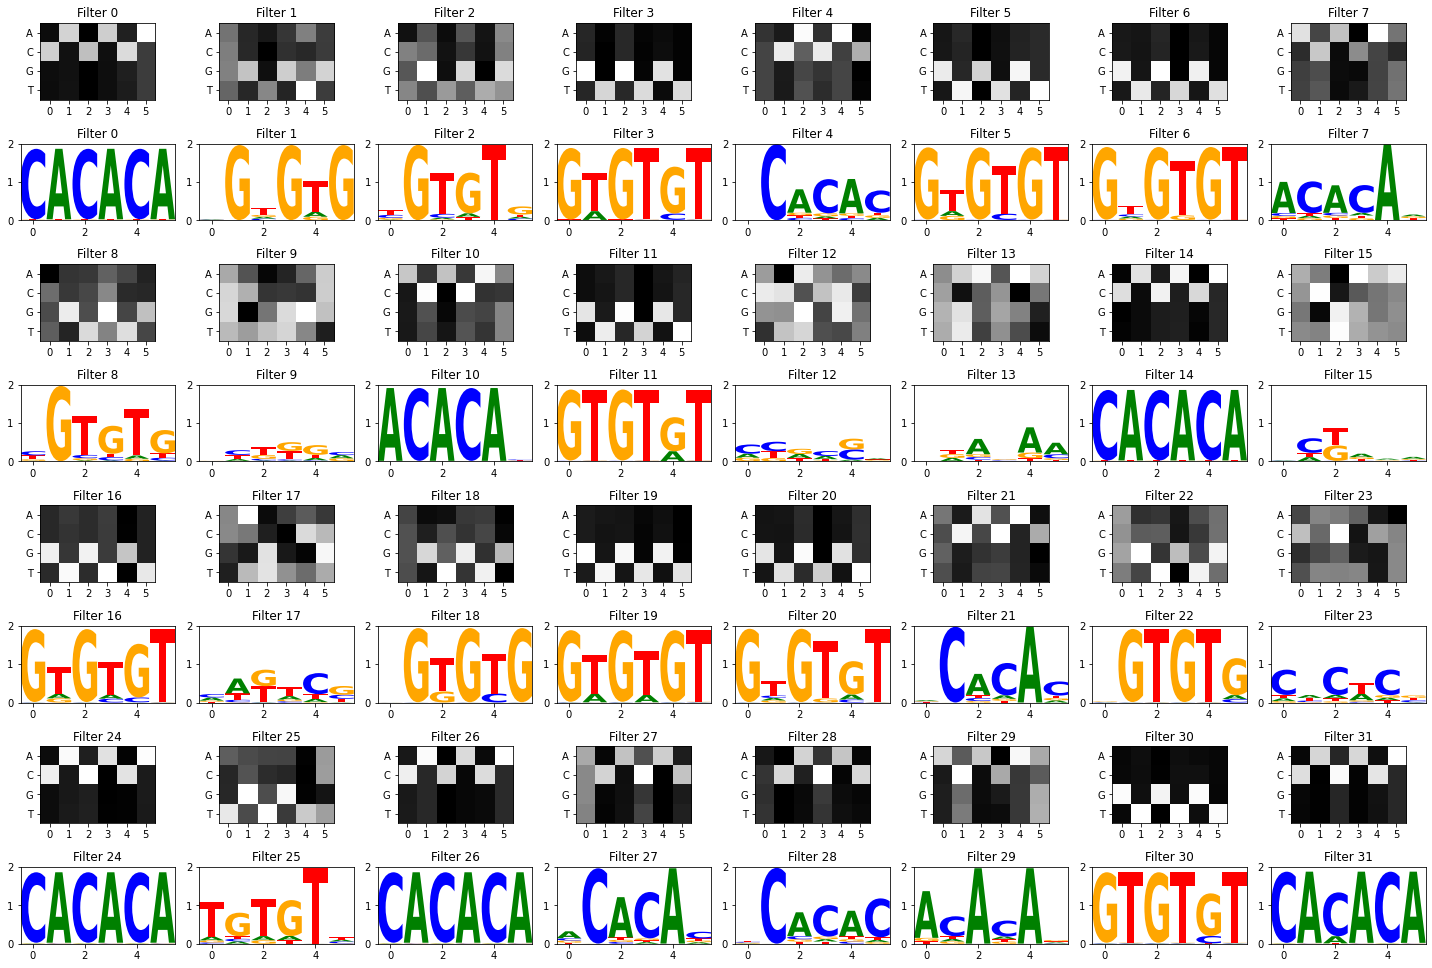

In [30]:
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
